In [1]:
import os
import pandas as pd
import fathon
from fathon import fathonUtils as fu
import numpy as np
from collections import defaultdict

In [84]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import stylised_facts_data_utilities as sfd_utils
import lob_for_futures as lobfut
import mdfda.mdfda_experiments_utils as mdf
%matplotlib inline
import os
figuresLocation = '/home/ak/Documents/Papers/StylisedFactsPaper/figures'

In [7]:
activityClockData = '/media/ak/My Passport/ExperimentData/ActivityClockData'
autoCorrelFolder = os.path.join(activityClockData, 'AutoCorrel')
clocksData = [f for f in os.listdir(activityClockData) if str('Clocks') in f]

In [126]:
symbol ='G_1'
symbolFiles = [f for f in os.listdir(autoCorrelFolder) if str(symbol) in f]

In [127]:
os.listdir(autoCorrelFolder)

['0AtoCorrelData_DU1_Comdty_20180416_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180417_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180418_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180419_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180420_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180423_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180424_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180425_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180426_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180427_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180430_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180502_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180503_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180523_.pkl',
 '0AtoCorrelData_DU1_Comdty_20180612_.pkl',
 '0AtoCorrelData_FB1_Comdty_20180502_.pkl',
 '0AtoCorrelData_FB1_Comdty_20180522_.pkl',
 '0AtoCorrelData_FB1_Comdty_20180611_.pkl',
 '0AtoCorrelData_FV1_Comdty_20180427_.pkl',
 '0AtoCorrelData_FV1_Comdty_20180517_.pkl',
 '0AtoCorrelData_FV1_Comdty_20180606_.pkl',
 '0AtoCorrelData_G_1_Comdty_20180427_.pkl',
 '0AtoCorrelData_G_1_Comdty_2018

In [128]:
correlVolumeClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('1AtoCorrelData') in s]))
correlTickClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('0AtoCorrelData') in s]))
correlDollarVolumeClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('2AtoCorrelData') in s]))


In [129]:
len(correlTickClock)

40

In [130]:
appended_data_volume_clock= []
appended_data_tick_clock= []
appended_data_dollar_volume_clock= []

for idx in range(0,len(correlVolumeClock)):
    fileIdx_volume_clock = os.path.join( autoCorrelFolder, correlVolumeClock[idx])
    fileIdx_dollar_clock = os.path.join( autoCorrelFolder, correlDollarVolumeClock[idx])
    fileIdx_tick_clock = os.path.join( autoCorrelFolder, correlTickClock[idx])
    
    appended_data_volume_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_volume_clock ).values()))
    appended_data_tick_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_tick_clock ).values()))
    appended_data_dollar_volume_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_dollar_clock ).values()))
    
    

In [131]:
appended_df_volume = pd.concat(appended_data_volume_clock, axis=1)
appended_df_tick = pd.concat(appended_data_tick_clock, axis=1)
appended_df_dollar_volume = pd.concat(appended_data_dollar_volume_clock, axis=1)


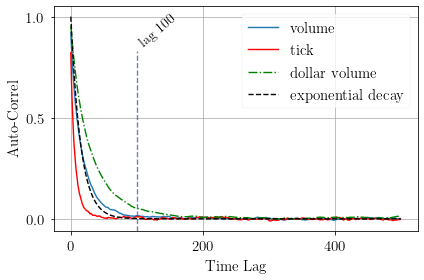

In [132]:
from matplotlib.ticker import AutoMinorLocator
size = 5
plt.params = {'legend.fontsize': '15',
          'figure.figsize': (16, 9),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 25}
plt.plot(appended_df_volume.median(axis=1), label ='volume')
plt.plot(appended_df_tick.median(axis=1), color ='r', label ='tick')
plt.plot(appended_df_dollar_volume.median(axis=1), color ='g', linestyle ='dashdot', label ='dollar volume')

N, tau = 1, 15
xlineLevel=100
# Maximum time to consider (s)
tmax = 500
ntau = tmax // tau + 1
# A suitable grid of time points, and the exponential decay itself
t = np.linspace(0, tmax, 400)
y = N * np.exp(-t / tau)

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(t, y, color='black', linestyle='--', label ='exponential decay')
plt.grid(True)
plt.xlabel("Time Lag", fontsize = 15)
plt.ylabel("Auto-Correl", fontsize = 15)
plt.axvline(x=xlineLevel, ymin=0.0, ymax=0.8, ls='--', alpha=0.7, color='#334f8d')
plt.yticks(fontsize=15)
plt.xticks(fontsize = 15)
plt.text(xlineLevel, 0.85, 'lag ' + str(xlineLevel), rotation=40, fontsize=14)
plt.legend(fontsize = 15, loc =1)
title = str(symbol)+'_auto_correl_clocks.png'
fig_location = os.path.join(figuresLocation , title)
plt.savefig(fig_location)
plt.show()


In [106]:
## Compute the sample average and std
sample_mean = np.mean(appended_df,axis=1)
sample_sd = np.std(appended_df,axis=1)

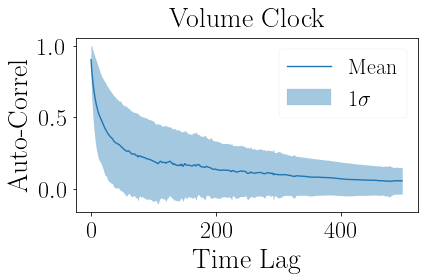

In [46]:
## Plot the sample average and std
plt.plot(range(499),sample_mean,"-",label="Mean")
plt.fill_between(
    range(499),
    sample_mean-sample_sd,
    sample_mean+sample_sd,
    alpha=0.4,
    color="C0",
    edgecolor="none",
    label=r"$1\sigma$")
plt.xlabel("Time Lag")
plt.ylabel("Auto-Correl")
plt.title('Volume Clock')
plt.legend()
plt.show()